Face detective functions

In [ ]:
!gdown '1MieUkDIgmMPup8-P6n-A1ZctpxMz-hZk'

Downloading...
From: https://drive.google.com/uc?id=1MieUkDIgmMPup8-P6n-A1ZctpxMz-hZk
To: /content/colab.zip
100% 3.21M/3.21M [00:00<00:00, 30.5MB/s]


In [ ]:
!unzip colab.zip

Archive:  colab.zip
   creating: small test/
  inflating: small test/050011.jpg   
  inflating: small test/050016.jpg   
  inflating: small test/050019.jpg   
  inflating: small test/050021.jpg   
  inflating: small test/050023.jpg   
  inflating: small test/050030.jpg   
  inflating: small test/050036.jpg   
  inflating: small test/050037.jpg   
  inflating: small test/050054.jpg   
  inflating: small test/050071.jpg   
  inflating: small test/050084.jpg   
  inflating: small test/050088.jpg   
  inflating: small test/050094.jpg   
   creating: test/
  inflating: test/050001.jpg         
  inflating: test/050002.jpg         
  inflating: test/050003.jpg         
  inflating: test/050004.jpg         
  inflating: test/050005.jpg         
  inflating: test/050006.jpg         
  inflating: test/050007.jpg         
  inflating: test/050008.jpg         
  inflating: test/050009.jpg         
  inflating: test/050010.jpg         
  inflating: test/050011.jpg         
  inflating: test/050012

In [ ]:
!pip install MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.7 MB/s eta 0:00:00


# **Phase 1:** Feature extraction

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import math
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from mtcnn import MTCNN

In [ ]:
import pandas as pd

# Paths to the source and destination CSV files
datasetPath1 = '/content/features.csv'
datasetPath2 = '/content/features2.csv'

# Read the source CSV file into a DataFrame
features_df = pd.read_csv(datasetPath1)

# Write the DataFrame to the destination CSV file
features_df.to_csv(datasetPath2, index=False)


In [ ]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f'Number of available CPU cores: {num_cores}')


Number of available CPU cores: 2


In [ ]:
import psutil

# Get the number of logical CPUs
cpu_count = psutil.cpu_count()

# Get per-core CPU usage
per_core_usage = psutil.cpu_percent(interval=1, percpu=True)

print(f"Number of logical CPUs: {cpu_count}")
print("Per-core CPU usage:")
for i, usage in enumerate(per_core_usage):
    print(f"Core {i}: {usage}%")


Number of logical CPUs: 2
Per-core CPU usage:
Core 0: 5.0%
Core 1: 5.0%


### Processing dataset to extract eye color and skin color features.

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from mtcnn import MTCNN
from skimage.color import rgb2lab, lab2rgb
from multiprocessing import Pool, cpu_count

# Function to map skin color shades to realistic colors
def map_skin_color_to_realistic_shade(average_rgb):
    lab_skin = rgb2lab(np.array([[average_rgb / 255]]))[0][0]
    L, a, b = lab_skin
    if L < 35:
        a, b = 18, 18
    elif L < 60:
        a, b = 15, 20
    else:
        a, b = 10, 25
    realistic_skin_lab = np.array([[L, a, b]])
    mapped_rgb = lab2rgb(realistic_skin_lab) * 255
    return mapped_rgb[0]

# Function to scale RGB values to a single value between 0 and 1
def scale_rgb_to_single_value(rgb):
    return np.mean(rgb) / 255

def process_image(args):
    index, row, dataset_path = args
    image_name = row['image_id']
    detector = MTCNN()

    image_path = os.path.join(dataset_path, image_name)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read the image {image_name}.")
        return index, None, None

    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(rgb_img)

    if faces:
        face = faces[0]
        x, y, width, height = face['box']

        # Calculate eye color
        left_eye_x_start, left_eye_y_start = x + int(width * 0.1), y + int(height * 0.3)
        eye_width, eye_height = width // 3, height // 5
        left_eye_roi = img[left_eye_y_start:left_eye_y_start + eye_height,
                           left_eye_x_start:left_eye_x_start + eye_width]
        right_eye_x_start, right_eye_y_start = x + int(width * 0.6), y + int(height * 0.3)
        right_eye_roi = img[right_eye_y_start:right_eye_y_start + eye_height,
                            right_eye_x_start:right_eye_x_start + eye_width]
        average_eye_rgb = (np.mean(left_eye_roi, axis=(0, 1)) + np.mean(right_eye_roi, axis=(0, 1))) / 2
        eye_color_single_value = scale_rgb_to_single_value(np.round(average_eye_rgb).astype(int))

        # Calculate skin color
        left_cheek_x_start, left_cheek_y_start = x + int(width * 0.2), y + int(height * 0.5)
        right_cheek_x_start, right_cheek_y_start = x + int(width * 0.6), y + int(height * 0.5)
        left_cheek_roi = img[left_cheek_y_start:left_cheek_y_start + int(height * 0.2),
                             left_cheek_x_start:left_cheek_x_start + int(width * 0.2)]
        right_cheek_roi = img[right_cheek_y_start:right_cheek_y_start + int(height * 0.2),
                              right_cheek_x_start:right_cheek_x_start + int(width * 0.2)]
        average_cheek_rgb = (np.mean(left_cheek_roi, axis=(0, 1)) + np.mean(right_cheek_roi, axis=(0, 1))) / 2
        mapped_cheek_rgb = map_skin_color_to_realistic_shade(average_cheek_rgb)
        skin_color_single_value = scale_rgb_to_single_value(np.round(mapped_cheek_rgb).astype(int))

        return index, eye_color_single_value, skin_color_single_value

    return index, None, None

def skincolor_eyecolor_to_dataset(dataset_path, csv_path, batch_size=500):
    # Load the existing dataset
    if os.path.exists(csv_path):
        features_df = pd.read_csv(csv_path)
        if 'eye_color' not in features_df.columns or 'skin_color' not in features_df.columns:
            features_df['eye_color'] = None
            features_df['skin_color'] = None
    else:
        print("CSV file not found.")
        return

    num_cores = cpu_count()
    num_processes = min(20, num_cores * 2)
    print(f"Using {num_processes} processes for multiprocessing.")

    num_images = len(features_df)
    num_epochs = (num_images + batch_size - 1) // batch_size

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}")

        start_idx = epoch * batch_size
        end_idx = min(start_idx + batch_size, num_images)
        batch_df = features_df.iloc[start_idx:end_idx]

        args = [(index, row, dataset_path) for index, row in batch_df.iterrows()]

        # Use multiprocessing to process images
        with Pool(processes=num_processes) as pool:
            results = pool.map(process_image, args)

        # Update DataFrame with results
        for index, eye_color, skin_color in results:
            if eye_color is not None and skin_color is not None:
                features_df.at[index, 'eye_color'] = eye_color
                features_df.at[index, 'skin_color'] = skin_color

        # Save updated DataFrame to CSV
        features_df.to_csv(csv_path, index=False)
        print(f"Epoch {epoch + 1} completed. Processed {end_idx - start_idx} images. CSV file updated.")

    print("All epochs completed. CSV file updated with eye color and skin color for all images.")

dataset_path = '/content/drive/MyDrive/dataset'
csv_path = '/content/drive/MyDrive/features2.csv'
skincolor_eyecolor_to_dataset(dataset_path, csv_path, batch_size=500)


Using 4 processes for multiprocessing.
Starting epoch 1/100
Epoch 1 completed. Processed 500 images. CSV file updated.
Starting epoch 2/100
Epoch 2 completed. Processed 500 images. CSV file updated.
Starting epoch 3/100
Epoch 3 completed. Processed 500 images. CSV file updated.
Starting epoch 4/100
Epoch 4 completed. Processed 500 images. CSV file updated.
Starting epoch 5/100
Epoch 5 completed. Processed 500 images. CSV file updated.
Starting epoch 6/100
Epoch 6 completed. Processed 500 images. CSV file updated.
Starting epoch 7/100
Epoch 7 completed. Processed 500 images. CSV file updated.
Starting epoch 8/100
Epoch 8 completed. Processed 500 images. CSV file updated.
Starting epoch 9/100
Epoch 9 completed. Processed 500 images. CSV file updated.
Starting epoch 10/100
Epoch 10 completed. Processed 500 images. CSV file updated.
Starting epoch 11/100
Epoch 11 completed. Processed 500 images. CSV file updated.
Starting epoch 12/100
Epoch 12 completed. Processed 500 images. CSV file upda

# **Phase 2:** Feature Selection

Processing image: 050036.jpg
Average eye color (R, G, B): [118.82239057  78.81060606 107.36111111]
Realistic average cheek color (R, G, B): [190.94564631 150.95101767 114.33059342]


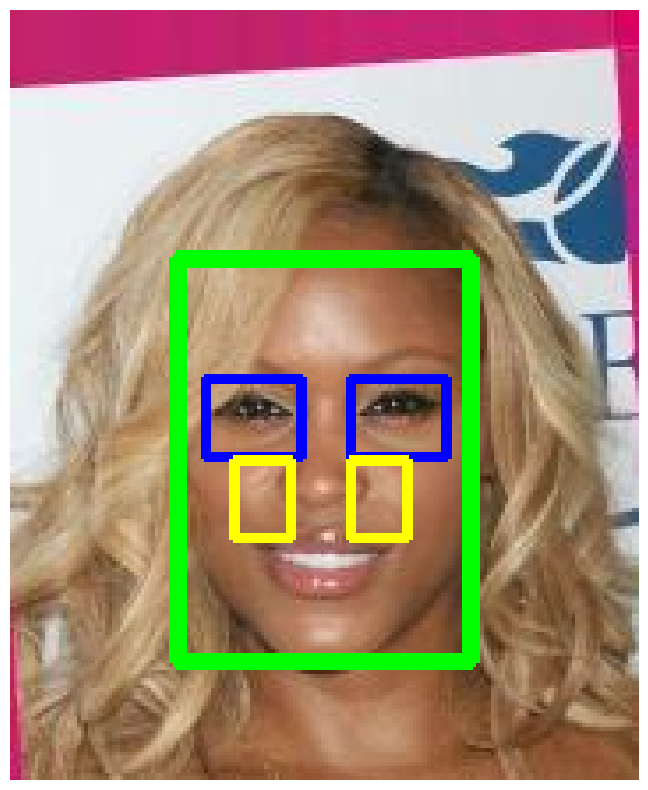

Processing image: 050019.jpg
Average eye color (R, G, B): [73.17832168 36.31293706 72.31293706]
Realistic average cheek color (R, G, B): [176.98453733 137.96709255 101.89067396]


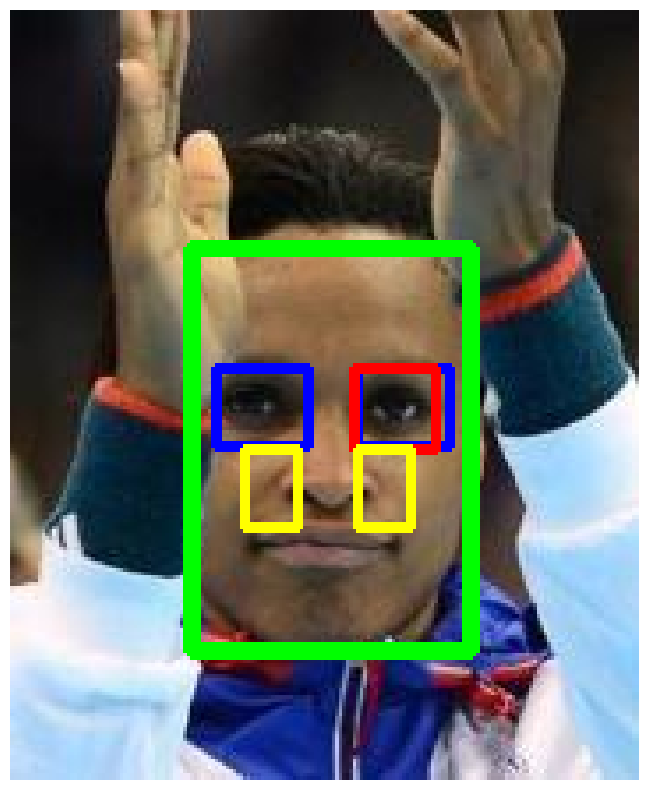

Processing image: 050037.jpg
Average eye color (R, G, B): [130.35897436  88.30677656 112.81227106]
Realistic average cheek color (R, G, B): [211.96285226 170.60756796 133.21546542]


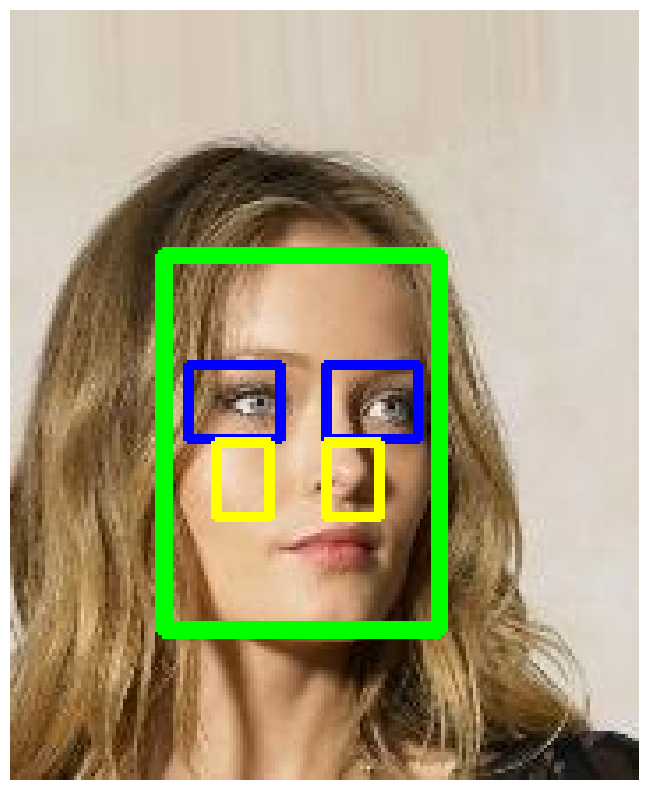

Processing image: 050088.jpg
Average eye color (R, G, B): [103.6173913   65.99637681 100.05434783]
Realistic average cheek color (R, G, B): [215.01278861 173.46990473 135.97021328]


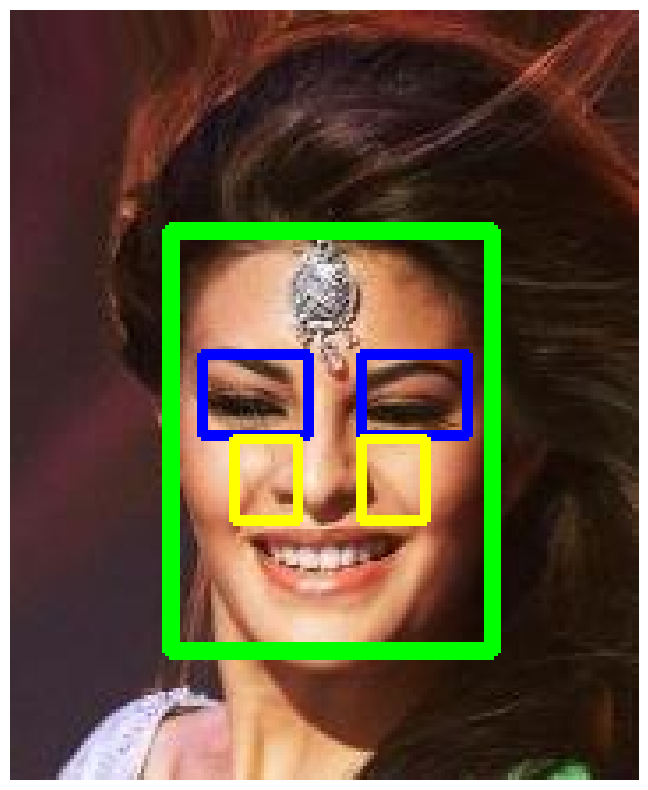

Processing image: 050016.jpg
Average eye color (R, G, B): [130.93881119  84.83566434 113.30244755]
Realistic average cheek color (R, G, B): [176.0404724  129.0304847  105.27829707]


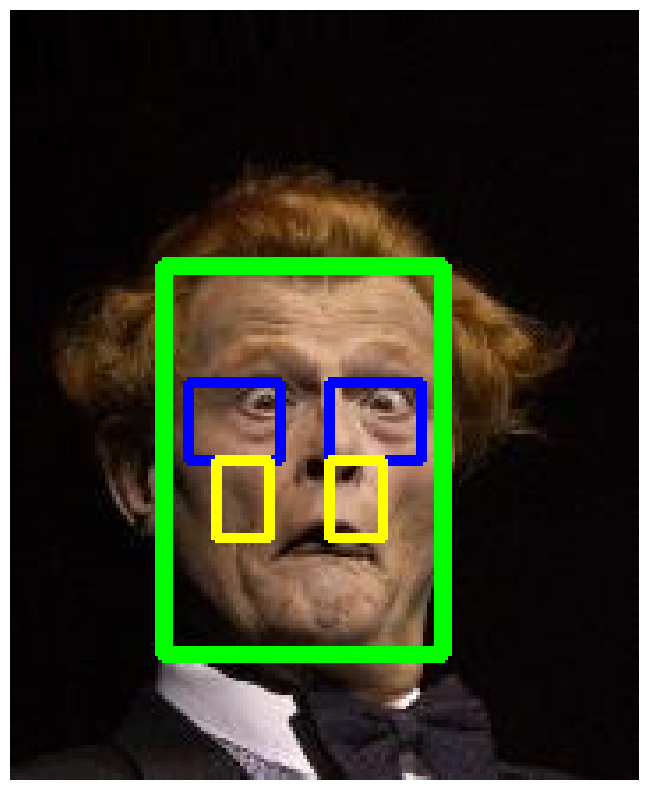

Processing image: 050071.jpg
Average eye color (R, G, B): [161.32307692 115.84230769 129.21634615]
Realistic average cheek color (R, G, B): [241.78797918 198.69144195 160.29049989]


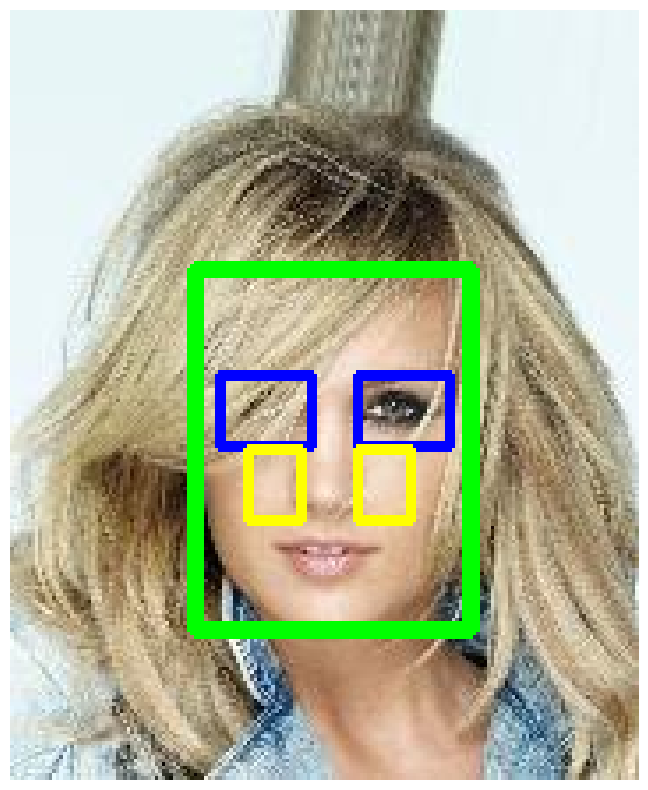

Processing image: 050084.jpg
Average eye color (R, G, B): [134.17321429 105.02232143 133.58928571]
Realistic average cheek color (R, G, B): [193.3035588  153.14999346 116.44024956]


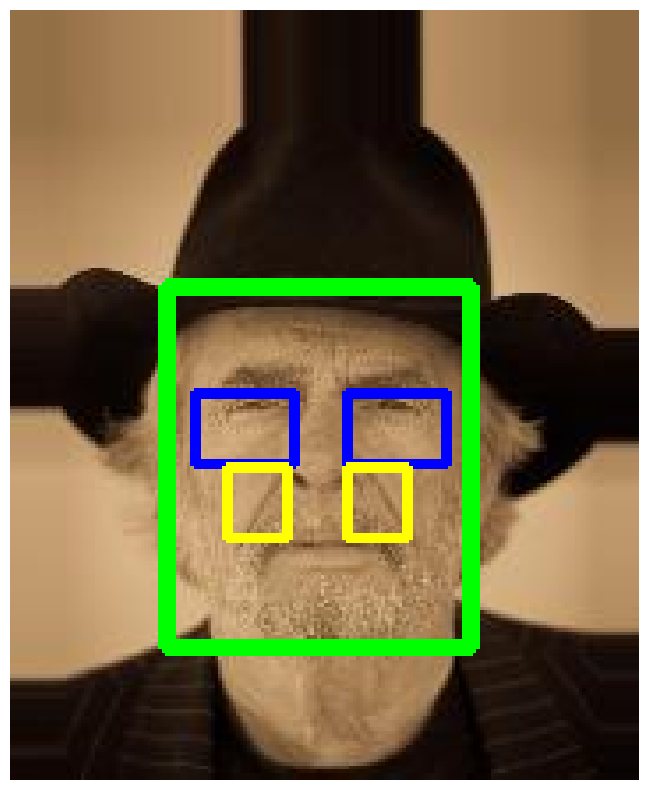

Processing image: 050094.jpg
Average eye color (R, G, B): [124.07894737  78.47975709 104.15182186]
Realistic average cheek color (R, G, B): [190.97230385 150.97586889 114.35443081]


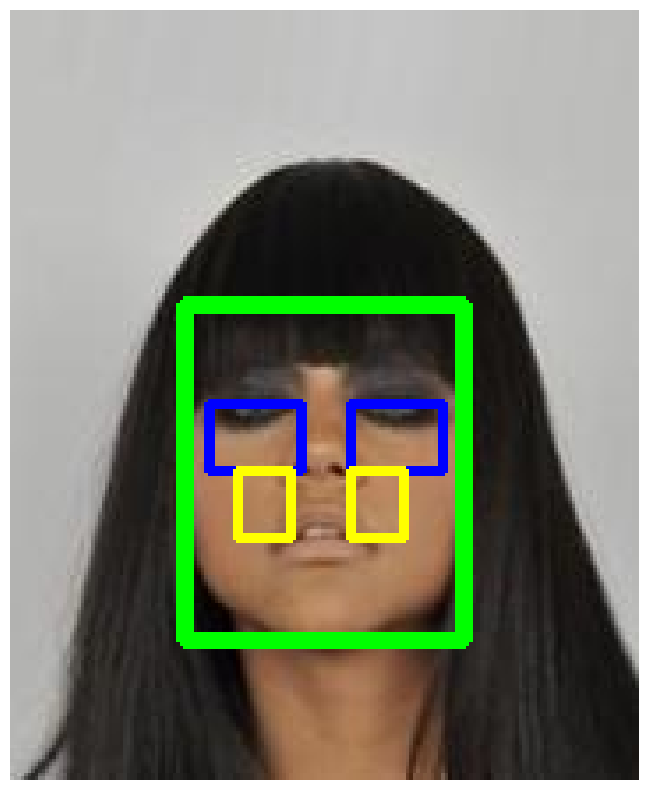

Processing image: 050023.jpg
Average eye color (R, G, B): [ 74.52681159  45.71884058 131.48695652]
Realistic average cheek color (R, G, B): [164.38176106 118.33043406  94.95909022]


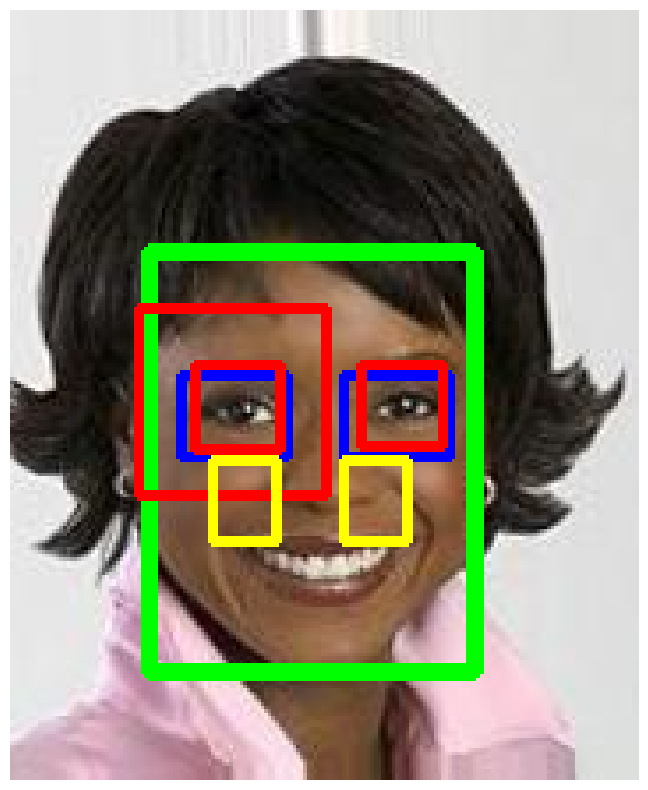

Processing image: 050030.jpg
Average eye color (R, G, B): [96.19855072 38.02826087 43.22826087]
Realistic average cheek color (R, G, B): [187.50456717 147.74494893 111.25617812]


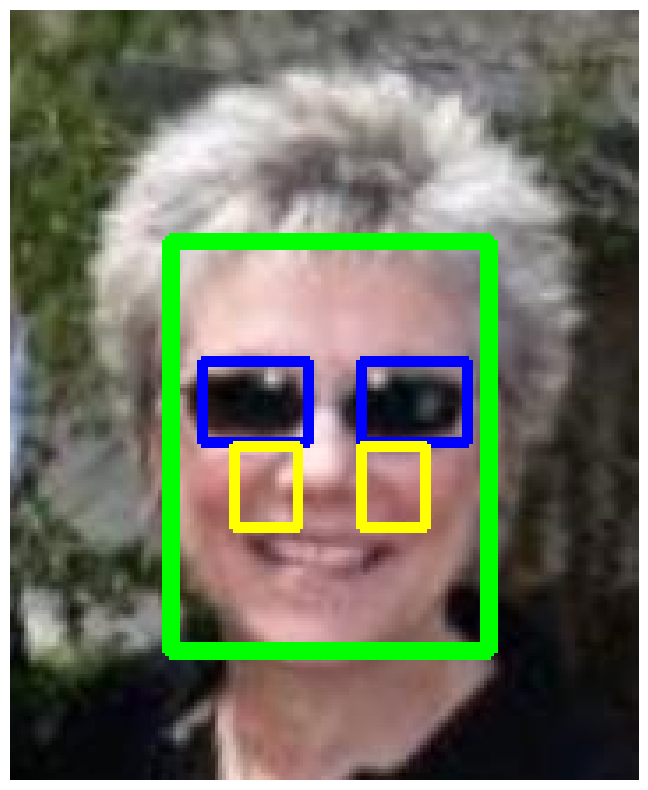

Processing image: 050011.jpg
Average eye color (R, G, B): [108.20538721  69.05892256 110.10185185]
Realistic average cheek color (R, G, B): [193.08913133 152.94995027 116.24829936]


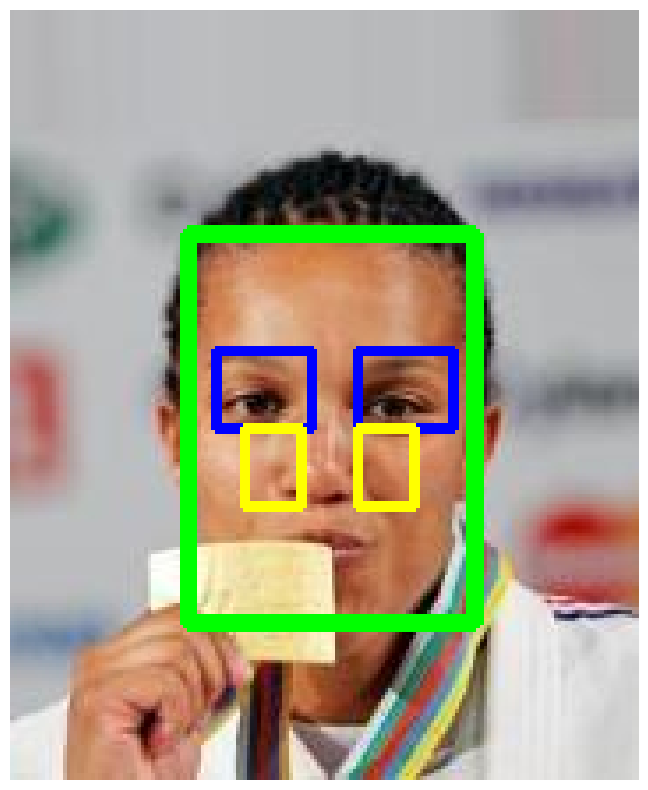

Processing image: 050054.jpg
Average eye color (R, G, B): [78.93241379 28.65172414 49.72551724]
Realistic average cheek color (R, G, B): [135.09470174  91.71726191  69.4084536 ]


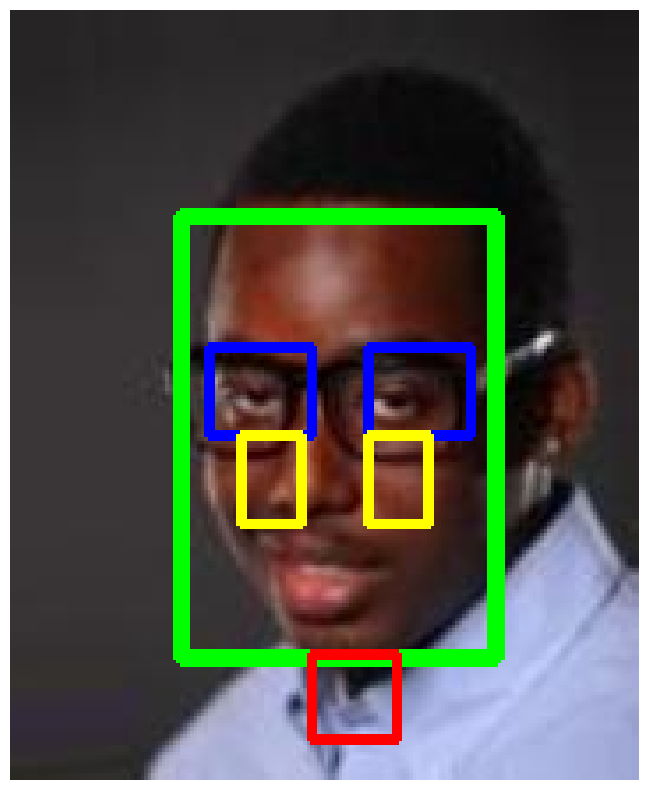

Faces detected in all images.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from mtcnn import MTCNN
from skimage.color import rgb2lab, lab2rgb  # For color mapping
import matplotlib.pyplot as plt

# Define the folder path containing the images
folderPath = '/content/small test'
datasetPath1 = '/content/drive/MyDrive/features.csv'
datasetPath2 = '/content/drive/MyDrive/features2.csv'

# Get a list of all image files in the folder
imageFiles = [f for f in os.listdir(folderPath) if f.endswith(('.png', '.jpg', '.jpeg'))]

# List to store the names of images where no face is detected
no_face_detected_images = []

# Initialize MTCNN detector
detector = MTCNN()

# List to store the coordinates of detected faces for averaging
all_faces_coordinates = []

# Load Haar Cascade for eye detection
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Function to map skin color shades to realistic colors
def map_skin_color_to_realistic_shade(average_rgb):
    lab_skin = rgb2lab(np.array([[average_rgb / 255]]))[0][0]
    L, a, b = lab_skin
    if L < 35:
        a, b = 18, 18
    elif L < 60:
        a, b = 15, 20
    else:
        a, b = 10, 25
    realistic_skin_lab = np.array([[L, a, b]])
    mapped_rgb = lab2rgb(realistic_skin_lab) * 255
    return mapped_rgb[0]

# Function to scale RGB values to a single value between 0 and 1
def scale_rgb_to_single_value(rgb):
    return np.mean(rgb) / 255

def skincolor_eyecolor_to_dataset(folderPath):
    if not imageFiles:
        print("Error: No images found in the folder.")
    else:
        for imageFile in imageFiles:
            imagePath = os.path.join(folderPath, imageFile)
            print(f"Processing image: {imageFile}")

            img = cv2.imread(imagePath)
            if img is None:
                print(f"Error: Could not read the image {imageFile}.")
                continue

            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces = detector.detect_faces(rgb_img)

            if faces:
                for face in faces:
                    x, y, width, height = face['box']
                    cv2.rectangle(img, (x, y), (x + width, y + height), (0, 255, 0), 4)

                    # Manually specified eye regions
                    eye_width, eye_height = width // 3, height // 5
                    left_eye_x_start, left_eye_y_start = x + int(width * 0.1), y + int(height * 0.3)
                    cv2.rectangle(img, (left_eye_x_start, left_eye_y_start),
                                  (left_eye_x_start + eye_width, left_eye_y_start + eye_height),
                                  (255, 0, 0), 2)

                    right_eye_x_start, right_eye_y_start = x + int(width * 0.6), y + int(height * 0.3)
                    cv2.rectangle(img, (right_eye_x_start, right_eye_y_start),
                                  (right_eye_x_start + eye_width, right_eye_y_start + eye_height),
                                  (255, 0, 0), 2)

                    # Detect eyes with OpenCV's CascadeClassifier
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    detected_eyes = eye_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)

                    # Draw rectangles around detected eyes
                    for (ex, ey, ew, eh) in detected_eyes:
                        cv2.rectangle(img, (ex, ey), (ex + ew, ey + eh), (0, 0, 255), 2)

                    left_eye_roi = img[left_eye_y_start:left_eye_y_start + eye_height,
                                       left_eye_x_start:left_eye_x_start + eye_width]
                    right_eye_roi = img[right_eye_y_start:right_eye_y_start + eye_height,
                                        right_eye_x_start:right_eye_x_start + eye_width]

                    average_left_eye_rgb = np.mean(left_eye_roi, axis=(0, 1))
                    average_right_eye_rgb = np.mean(right_eye_roi, axis=(0, 1))
                    average_eye_rgb = (average_left_eye_rgb + average_right_eye_rgb) / 2

                    left_cheek_x_start, left_cheek_y_start = x + int(width * 0.2), y + int(height * 0.5)
                    left_cheek_x_end, left_cheek_y_end = left_cheek_x_start + int(width * 0.2), left_cheek_y_start + int(height * 0.2)
                    cv2.rectangle(img, (left_cheek_x_start, left_cheek_y_start), (left_cheek_x_end, left_cheek_y_end), (0, 255, 255), 2)

                    right_cheek_x_start, right_cheek_y_start = x + int(width * 0.6), y + int(height * 0.5)
                    right_cheek_x_end, right_cheek_y_end = right_cheek_x_start + int(width * 0.2), right_cheek_y_start + int(height * 0.2)
                    cv2.rectangle(img, (right_cheek_x_start, right_cheek_y_start), (right_cheek_x_end, right_cheek_y_end), (0, 255, 255), 2)

                    left_cheek_roi = img[left_cheek_y_start:left_cheek_y_end, left_cheek_x_start:left_cheek_x_end]
                    right_cheek_roi = img[right_cheek_y_start:right_cheek_y_end, right_cheek_x_start:right_cheek_x_end]

                    average_left_cheek_rgb = np.mean(left_cheek_roi, axis=(0, 1))
                    average_right_cheek_rgb = np.mean(right_cheek_roi, axis=(0, 1))
                    average_cheek_rgb = (average_left_cheek_rgb + average_right_cheek_rgb) / 2
                    mapped_cheek_rgb = map_skin_color_to_realistic_shade(average_cheek_rgb)

                    print(f"Average eye color (R, G, B): {average_eye_rgb}")
                    print(f"Realistic average cheek color (R, G, B): {mapped_cheek_rgb}")

                    eye_color_single_value = scale_rgb_to_single_value(np.round(average_eye_rgb).astype(int))
                    skin_color_single_value = scale_rgb_to_single_value(np.round(mapped_cheek_rgb).astype(int))
            else:
                no_face_detected_images.append(imageFile)

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(20, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()

    if no_face_detected_images and all_faces_coordinates:
        avg_face_coordinates = np.mean(all_faces_coordinates, axis=0).astype(int)
        avg_x, avg_y, avg_width, avg_height = avg_face_coordinates
        print(f"Average face coordinates: {avg_face_coordinates}")

        for imageFile in no_face_detected_images:
            imagePath = os.path.join(folderPath, imageFile)
            img = cv2.imread(imagePath)
            if img is not None:
                cv2.rectangle(img, (avg_x, avg_y), (avg_x + avg_width, avg_y + avg_height), (255, 0, 0), 4)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 5))
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.show()

    if no_face_detected_images:
        print("Images with no faces detected:", no_face_detected_images)
    else:
        print("Faces detected in all images.")

skincolor_eyecolor_to_dataset(folderPath)


In [ ]:
import csv
import math

In [ ]:
# Load data from CSV file
data = []
feature_names = []

# Open the CSV file and extract feature names and data
with open('features.csv', mode='r') as file:
    reader = csv.reader(file)
    feature_names = next(reader)[1:]  # Get feature names from the header row, skipping the first column (filenames)

    for row in reader:
        # Extract integer values from each row, skipping the filename
        int_values = [int(value) for value in row[1:]]  # Start from index 1 to skip the filename
        data.append(int_values)

# Transpose data to access each feature easily
data_transposed = list(zip(*data))

# Calculate mean of each feature
means = [sum(feature) / len(feature) for feature in data_transposed]

# Function to calculate covariance between two features
def covariance(X, Y, mean_X, mean_Y):
    return sum((X[i] - mean_X) * (Y[i] - mean_Y) for i in range(len(X))) / len(X)

# Function to calculate variance of a feature
def variance(X, mean_X):
    return sum((x - mean_X) ** 2 for x in X) / len(X)

# Function to calculate Pearson correlation between two features
def correlation(X, Y, mean_X, mean_Y):
    cov = covariance(X, Y, mean_X, mean_Y)
    std_X = math.sqrt(variance(X, mean_X))
    std_Y = math.sqrt(variance(Y, mean_Y))
    return cov / (std_X * std_Y)

# Calculate the correlation matrix
correlation_matrix = []
for i in range(len(data_transposed)):
    row = []
    for j in range(len(data_transposed)):
        if i == j:
            row.append(1)  # Correlation with itself is 1
        else:
            correlation_value = correlation(data_transposed[i], data_transposed[j], means[i], means[j])
            row.append(round(correlation_value, 2))
    correlation_matrix.append(row)

# Print the correlation matrix
print("Correlation Matrix:")
for row in correlation_matrix:
    print(row)

# Sum of absolute correlations for each feature
absolute_correlation_sums = []
for i in range(len(correlation_matrix)):
    abs_sum = sum([abs(correlation_matrix[i][j]) for j in range(len(correlation_matrix))])
    absolute_correlation_sums.append((i, abs_sum))

# Try different thresholds and print features selected for each
thresholds = [3, 3.5, 3.8, 4, 4.5, 5]

optimum_features = None
optimum_features2 = None
features_to_add = ["eye_color", "skin_color"]

for threshold in thresholds:
    # Select features where the sum of absolute correlations is less than the threshold
    selected_features_indices = [i for i, abs_sum in absolute_correlation_sums if abs_sum < threshold]

    # Step 3: Print the feature names and their correlation sum
    selected_feature_names = [feature_names[index] for index in selected_features_indices]

    print(f"\nFor threshold {threshold}, selected features ({len(selected_features_indices)}):")
    #print(selected_feature_names)
    if len(selected_features_indices) >= 6:
        optimum_features = selected_feature_names
        optimum_features2 = selected_feature_names + features_to_add
        print(selected_feature_names)
        print(optimum_features2)
        print("Optimum threshold found.")
        break

Correlation Matrix:
[1, -0.16, -0.07, 0.16, 0.01, -0.08, -0.04, 0.15, 0.09, -0.13, -0.03, -0.01, 0.22, -0.01, 0.0, 0.02, 0.15, -0.04, -0.28, -0.16, 0.42, -0.07, 0.09, 0.02, -0.53, -0.08, -0.04, -0.02, -0.03, -0.09, 0.26, -0.07, 0.05, -0.12, -0.16, 0.04, -0.33, -0.11, 0.1, 0.01]
[-0.16, 1, 0.26, -0.08, -0.07, -0.03, 0.24, -0.08, 0.0, 0.12, -0.08, 0.01, -0.01, -0.09, -0.08, -0.15, -0.11, -0.1, 0.44, 0.16, -0.4, 0.07, -0.08, 0.02, 0.2, -0.02, 0.05, 0.16, -0.01, 0.23, -0.12, 0.1, -0.05, 0.2, 0.29, -0.1, 0.46, 0.21, -0.13, 0.15]
[-0.07, 0.26, 1, -0.17, -0.15, 0.07, 0.07, -0.28, 0.0, 0.15, -0.18, 0.14, 0.04, -0.24, -0.21, -0.22, -0.15, -0.2, 0.48, 0.15, -0.4, 0.02, -0.14, -0.07, 0.2, 0.2, 0.08, 0.23, -0.18, 0.17, -0.1, 0.15, 0.04, 0.22, 0.13, -0.14, 0.49, 0.07, -0.16, 0.39]
[0.16, -0.08, -0.17, 1, 0.12, -0.06, -0.0, 0.36, 0.0, -0.1, -0.04, -0.05, 0.11, 0.15, 0.19, -0.05, 0.09, 0.17, -0.29, 0.07, 0.29, 0.05, 0.1, 0.11, -0.14, -0.13, -0.03, -0.11, 0.11, -0.09, 0.1, 0.11, 0.02, -0.12, -0.1, -0.

In [ ]:
path = '/content/test_features.csv'
path1 = '/content/features.csv'
path2 = '/content/features2.csv'
# Assuming data is already loaded into data1 and data2
# Example: scaled_data1, scaled_data2
data1 = pd.read_csv(path1)[optimum_features]
data2 = pd.read_csv(path2)[optimum_features2]

# **Phase 3:** Clustering

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
path = '/content/test_features.csv'
path1 = '/content/features.csv'
path2 = '/content/features2.csv'
# Assuming data is already loaded into data1 and data2
# Example: scaled_data1, scaled_data2
data1 = pd.read_csv(path1)[optimum_features]
data2 = pd.read_csv(path2)[optimum_features2]

In [69]:
# Scale the data to ensure all features contribute equally
scaler = StandardScaler()
scaled_data1 = scaler.fit_transform(data1)  # For feature.csv
scaled_data2 = scaler.fit_transform(data2)  # For feature2.csv

K=means

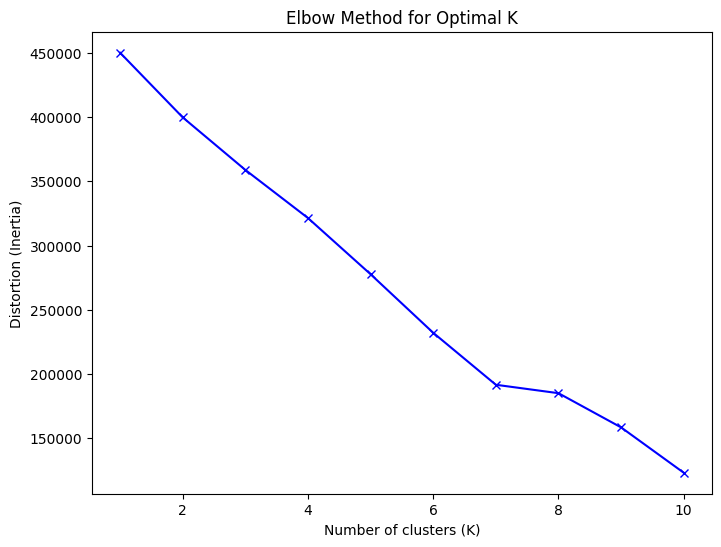

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Load the CSV file
data =  data1

# Step 2: Preprocess the data
# Remove any non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Check if any columns were dropped
dropped_columns = data.columns.difference(numeric_data.columns)
if len(dropped_columns) > 0:
    print(f"Dropped non-numeric columns: {list(dropped_columns)}")

# Standardize the numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Step 3: Use the elbow method to find the optimal K (number of clusters)
def find_optimal_k(data):
    distortions = []
    K_range = range(1, 11)  # You can change this range for larger data
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method for Optimal K')
    plt.show()

    return distortions

distortions = find_optimal_k(scaled_data)



Dropped non-numeric columns: ['image_id']
Silhouette Score for K-means with 8 clusters: 0.07540068668226424


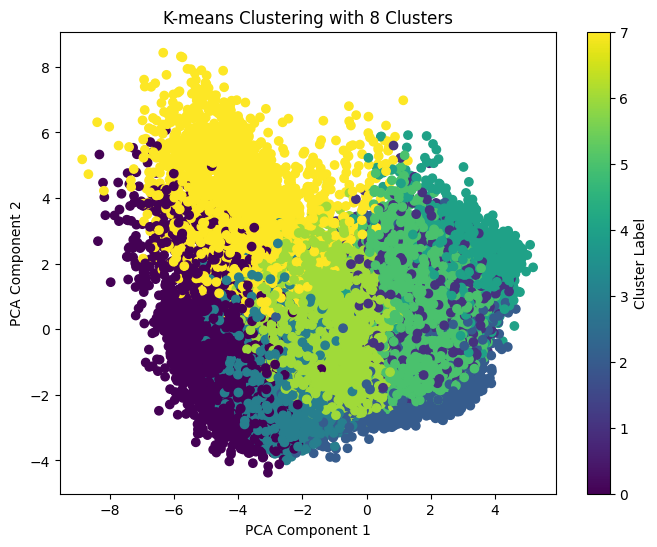

Cluster 0: ['000020.jpg', '000037.jpg', '000076.jpg', '000109.jpg', '000119.jpg', '000122.jpg', '000135.jpg', '000164.jpg', '000207.jpg', '000210.jpg']
Cluster 1: ['000024.jpg', '000029.jpg', '000054.jpg', '000071.jpg', '000094.jpg', '000100.jpg', '000111.jpg', '000125.jpg', '000132.jpg', '000139.jpg']
Cluster 2: ['000019.jpg', '000048.jpg', '000089.jpg', '000104.jpg', '000121.jpg', '000148.jpg', '000163.jpg', '000195.jpg', '000198.jpg', '000222.jpg']
Cluster 3: ['000007.jpg', '000008.jpg', '000015.jpg', '000016.jpg', '000023.jpg', '000025.jpg', '000041.jpg', '000053.jpg', '000061.jpg', '000064.jpg']
Cluster 4: ['000009.jpg', '000018.jpg', '000022.jpg', '000042.jpg', '000063.jpg', '000075.jpg', '000085.jpg', '000092.jpg', '000099.jpg', '000106.jpg']
Cluster 5: ['000001.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000010.jpg', '000014.jpg', '000027.jpg', '000028.jpg', '000034.jpg', '000035.jpg']
Cluster 6: ['000002.jpg', '000003.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '00001

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the CSV file
data = pd.read_csv('/content/features.csv')

# Preprocess the data
# Separate the image IDs
image_ids = data['image_id']

# Remove any non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Check if any columns were dropped
dropped_columns = data.columns.difference(numeric_data.columns)
if len(dropped_columns) > 0:
    print(f"Dropped non-numeric columns: {list(dropped_columns)}")

# Drop rows with missing values and update image_ids accordingly
numeric_data = numeric_data.dropna()
image_ids = image_ids[numeric_data.index]

# Choose K based on the elbow and evaluate using silhouette score
kb = 8

# Perform K-means clustering using the best K
kmeans_best = KMeans(n_clusters=kb, random_state=42)
kmeans_best.fit(scaled_data)

cluster_labels_best = kmeans_best.labels_

# Plot the clusters using PCA for visualization (if data is multi-dimensional)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

sil_score = silhouette_score(scaled_data, cluster_labels_best)

print(f"Silhouette Score for K-means with {kb} clusters: {sil_score}")

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels_best, cmap='viridis')
plt.title(f"K-means Clustering with {kb} Clusters")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Print the names of 10 pictures in each cluster
for cluster in range(kb):
    cluster_indices = np.where(cluster_labels_best == cluster)[0]
    cluster_image_ids = image_ids.iloc[cluster_indices].head(10).tolist()
    print(f"Cluster {cluster}: {cluster_image_ids}")


DBscan

Best DBSCAN params for data1: {'eps': 1.0, 'min_samples': 2}
Best DBSCAN silhouette score for data1: 0.47759633860666234
Number of clusters: 18
Number of noise points: 13


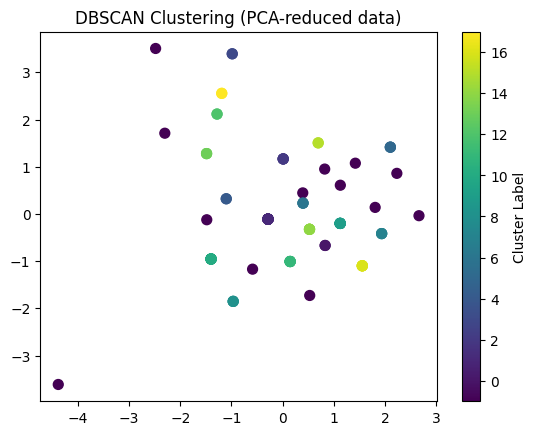


Cluster 0:
050001.jpg
050090.jpg

Cluster 1:
050002.jpg
050011.jpg
050016.jpg

Cluster 2:
050003.jpg
050012.jpg
050022.jpg

Cluster 3:
050004.jpg
050074.jpg

Cluster 4:
050005.jpg
050097.jpg

Cluster 5:
050006.jpg
050013.jpg
050056.jpg

Cluster 6:
050007.jpg
050057.jpg
050077.jpg

Cluster 7:
050009.jpg
050047.jpg
050081.jpg

Cluster 8:
050010.jpg
050038.jpg
050096.jpg

Cluster 9:
050014.jpg
050018.jpg
050031.jpg

Cluster 10:
050019.jpg
050027.jpg
050029.jpg

Cluster 11:
050021.jpg
050035.jpg
050058.jpg

Cluster 12:
050025.jpg
050084.jpg

Cluster 13:
050030.jpg
050039.jpg
050046.jpg

Cluster 14:
050032.jpg
050045.jpg
050061.jpg

Cluster 15:
050036.jpg
050088.jpg

Cluster 16:
050042.jpg
050050.jpg
050079.jpg

Cluster 17:
050053.jpg
050076.jpg


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
data = pd.read_csv('test_features.csv')

# Extract image IDs
image_ids = data['image_id']

# Select only the optimum features for clustering
data1 = data[optimum_features]

# Normalize the data
scaler = StandardScaler()
scaled_data1 = scaler.fit_transform(data1)

# Define a custom scoring function for silhouette score
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)

    # Check if there is more than 1 cluster to calculate silhouette score
    if len(set(cluster_labels)) > 1:
        score = silhouette_score(X, cluster_labels)
    else:
        score = -1  # If only one cluster or no valid clusters, return nan

    return score

# Adjust the parameter grid for DBSCAN
param_grid_dbscan = {
    'eps': np.arange(1, 2.25, 0.05),
    'min_samples': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Use GridSearchCV with the custom silhouette scorer for DBSCAN
grid_dbscan = GridSearchCV(DBSCAN(), param_grid_dbscan, scoring=silhouette_scorer, cv=3)
grid_dbscan.fit(scaled_data1)

# Get the best parameters and score
best_dbscan_params = grid_dbscan.best_params_
best_dbscan_score = grid_dbscan.best_score_

# Output the best results
print("Best DBSCAN params for data1:", best_dbscan_params)
print("Best DBSCAN silhouette score for data1:", best_dbscan_score)

# Fit DBSCAN with the best params
best_dbscan = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
labels = best_dbscan.fit_predict(scaled_data1)

# Diagnostic: Count noise points and number of clusters
n_noise = list(labels).count(-1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Handle potential edge case: if no clusters are formed
if n_clusters == 0:
    print("Warning: No clusters were found. Try increasing 'eps' or lowering 'min_samples'.")

# PCA for visualization (reducing the data to 2D)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data1)

# Plot the PCA-reduced data with cluster labels
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering (PCA-reduced data)')
plt.colorbar(label='Cluster Label')
plt.show()

# Print the image IDs for 3 pictures in each cluster
unique_labels = np.unique(labels)
for label in unique_labels:
    if label != -1:  # Skip noise points
        cluster_indices = np.where(labels == label)[0]
        cluster_image_ids = image_ids.iloc[cluster_indices]
        print(f"\nCluster {label}:")
        for image_id in cluster_image_ids.head(3):
            print(image_id)


MeanShift

Estimated Bandwidth: 2.58
Silhouette Score: 0.34804307086636493


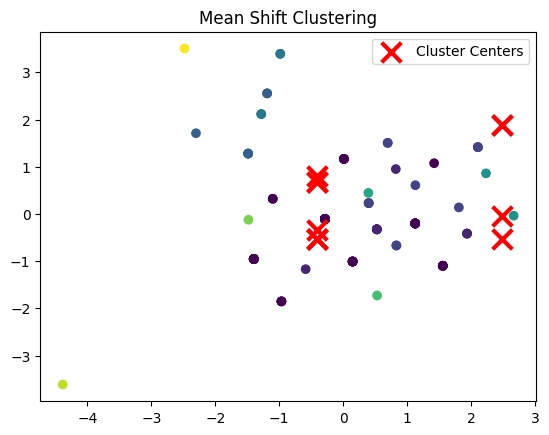

Cluster 0: ['050002.jpg', '050003.jpg', '050005.jpg']
Cluster 1: ['050009.jpg', '050023.jpg', '050032.jpg']
Cluster 2: ['050001.jpg', '050006.jpg', '050007.jpg']
Cluster 3: ['050030.jpg', '050039.jpg', '050046.jpg']
Cluster 4: ['050004.jpg', '050025.jpg', '050074.jpg']
Cluster 5: ['050069.jpg', '050099.jpg']
Cluster 6: ['050017.jpg']
Cluster 7: ['050094.jpg']
Cluster 8: ['050034.jpg']
Cluster 9: ['050060.jpg']
Cluster 10: ['050015.jpg']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Load the data from CSV
df = pd.read_csv('test_features.csv')
data = df[optimum_features]
image_ids = df['image_id']

# Step 2: Preprocess the data (Scaling is important for MeanShift)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 3: Estimate bandwidth for Mean Shift
bandwidth = round(estimate_bandwidth(scaled_data, quantile=0.2, n_samples=500), 2)  # Adjust the quantile and sample size if necessary
print(f'Estimated Bandwidth: {bandwidth}')

# Step 4: Apply Mean Shift Clustering with the estimated bandwidth
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift.fit(scaled_data)

# Step 5: Get cluster labels
labels = mean_shift.labels_

# Step 6: Calculate Silhouette Score
if len(np.unique(labels)) > 1:  # Silhouette score is undefined for a single cluster
    score = silhouette_score(scaled_data, labels)
    print(f'Silhouette Score: {score}')
else:
    print("Only one cluster found, silhouette score cannot be calculated.")

# Step 7: Visualize clusters using PCA to reduce to 2D (if the data has more than 2 features)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Step 8: Plot the clustering result
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1],
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering')
plt.legend()
plt.show()

# Step 9: Print the image IDs for 3 pictures in each cluster
cluster_df = pd.DataFrame({'image_id': image_ids, 'label': labels})
for cluster_label in np.unique(labels):
    cluster_images = cluster_df[cluster_df['label'] == cluster_label]['image_id'].head(3).tolist()
    print(f"Cluster {cluster_label}: {cluster_images}")


Running k_means with feature2.csv

Silhouette Score for K-means with 8 clusters: 0.07540068668226424


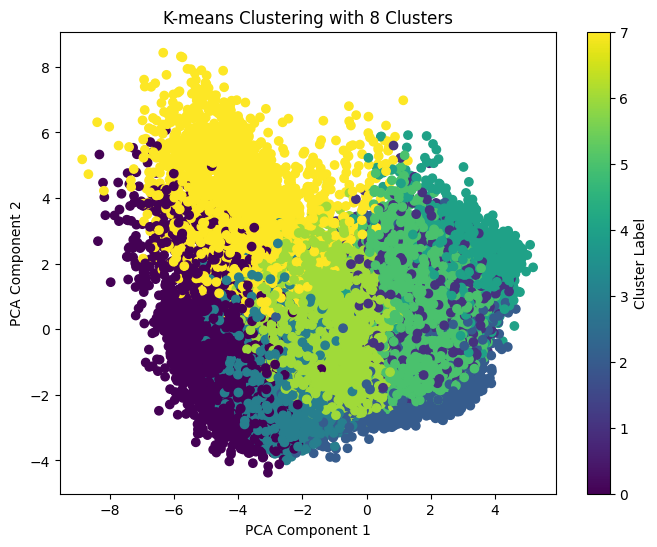

Cluster 0: ['000020.jpg', '000037.jpg', '000076.jpg', '000109.jpg', '000119.jpg', '000123.jpg', '000136.jpg', '000166.jpg', '000210.jpg', '000213.jpg']
Cluster 1: ['000024.jpg', '000029.jpg', '000054.jpg', '000071.jpg', '000094.jpg', '000100.jpg', '000111.jpg', '000126.jpg', '000133.jpg', '000140.jpg']
Cluster 2: ['000019.jpg', '000048.jpg', '000089.jpg', '000104.jpg', '000122.jpg', '000150.jpg', '000165.jpg', '000197.jpg', '000201.jpg', '000225.jpg']
Cluster 3: ['000007.jpg', '000008.jpg', '000015.jpg', '000016.jpg', '000023.jpg', '000025.jpg', '000041.jpg', '000053.jpg', '000061.jpg', '000064.jpg']
Cluster 4: ['000009.jpg', '000018.jpg', '000022.jpg', '000042.jpg', '000063.jpg', '000075.jpg', '000085.jpg', '000092.jpg', '000099.jpg', '000106.jpg']
Cluster 5: ['000001.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000010.jpg', '000014.jpg', '000027.jpg', '000028.jpg', '000034.jpg', '000035.jpg']
Cluster 6: ['000002.jpg', '000003.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '00001

In [ ]:
data = data2
data = pd.read_csv('/content/features2.csv')


# Separate the image IDs
image_ids = data['image_id']

# Remove any non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Drop rows with missing values and update image_ids accordingly
numeric_data = numeric_data.dropna()
image_ids = image_ids[numeric_data.index]

# Choose K based on the elbow and evaluate using silhouette score
kb = 8

# Perform K-means clustering using the best K
kmeans_best = KMeans(n_clusters=kb, random_state=42)
kmeans_best.fit(scaled_data)

cluster_labels_best = kmeans_best.labels_

# Plot the clusters using PCA for visualization (if data is multi-dimensional)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

sil_score = silhouette_score(scaled_data, cluster_labels_best)

print(f"Silhouette Score for K-means with {kb} clusters: {sil_score}")

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels_best, cmap='viridis')
plt.title(f"K-means Clustering with {kb} Clusters")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Print the names of 10 pictures in each cluster
for cluster in range(kb):
    cluster_indices = np.where(cluster_labels_best == cluster)[0]
    cluster_image_ids = image_ids.iloc[cluster_indices].head(10).tolist()
    print(f"Cluster {cluster}: {cluster_image_ids}")


Comparing

Silhouette Score as a primary metric to evaluate clustering efficiency

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores
silhouette_kmeans1 = silhouette_score(scaled_data1, kmeans_labels1)
silhouette_dbscan1 = silhouette_score(scaled_data1, dbscan_labels1)
silhouette_meanshift1 = silhouette_score(scaled_data1, meanshift_labels1)

print(f"KMeans Silhouette Score: {silhouette_kmeans1}")
print(f"DBSCAN Silhouette Score: {silhouette_dbscan1}")
print(f"MeanShift Silhouette Score: {silhouette_meanshift1}")

KMeans Silhouette Score: 0.2536895120352182
DBSCAN Silhouette Score: 0.42537788017813255
MeanShift Silhouette Score: 0.8699999965750763


Heatmap Visualization

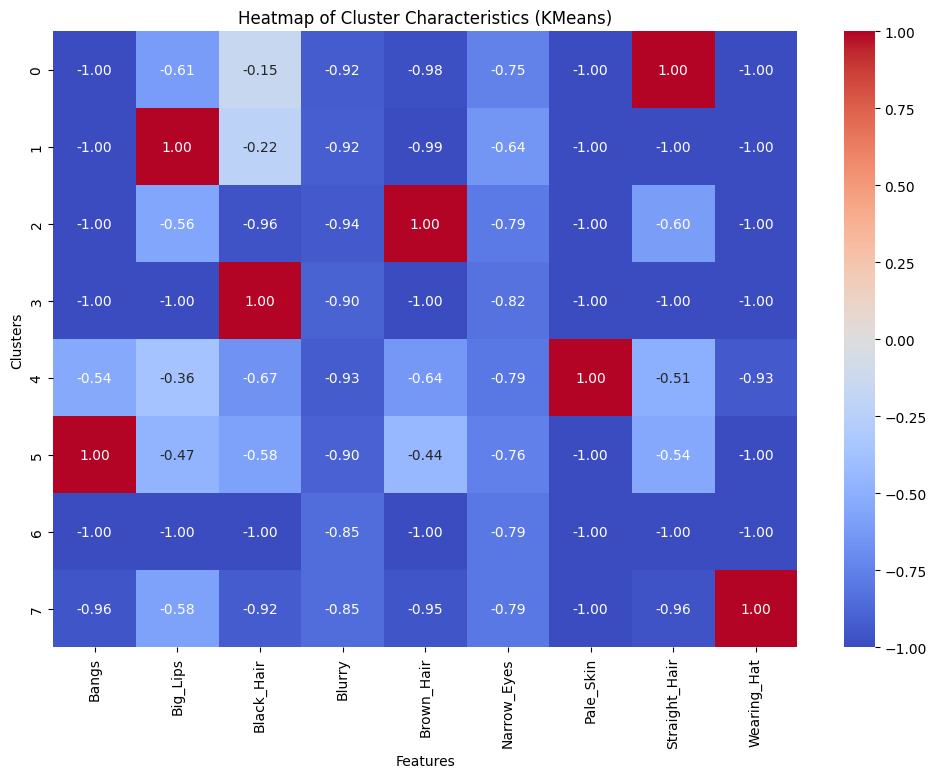

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load and normalize the data
data1 = pd.read_csv('features.csv')[optimum_features]
scaler = StandardScaler()
scaled_data1 = scaler.fit_transform(data1)

# Step 2: Fit KMeans
best_kmeans_model = KMeans(n_clusters=8, random_state=42)
labels_kmeans = best_kmeans_model.fit_predict(scaled_data1)

# Step 3: Add cluster labels to the DataFrame
data1['Cluster'] = labels_kmeans

# Step 4: Calculate the mean values of each feature for each cluster
cluster_means = data1.groupby('Cluster').mean()

# Step 5: Plot a heatmap for the cluster comparison
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
plt.title("Heatmap of Cluster Characteristics (KMeans)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()



# **Phase 4: Visualization**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


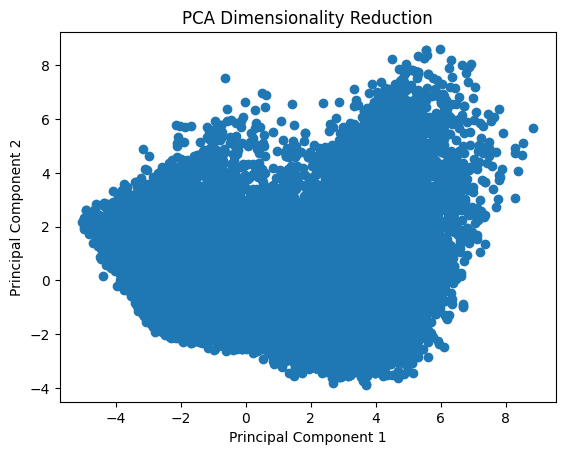

In [ ]:
# Load the dataset
path = '/content/features.csv'
data = pd.read_csv(path)

# Exclude non-numeric columns (like 'image_id') and use only numeric features
features = [col for col in data.columns if data[col].dtype.name in ['int64', 'float64']]

# Select the numeric data
X = data[features]

# Standardize the features (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a new DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualization
plt.scatter(principal_df['PC1'], principal_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Dimensionality Reduction')
plt.show()


# **Phase 5: KNN & K-Means**

(3, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


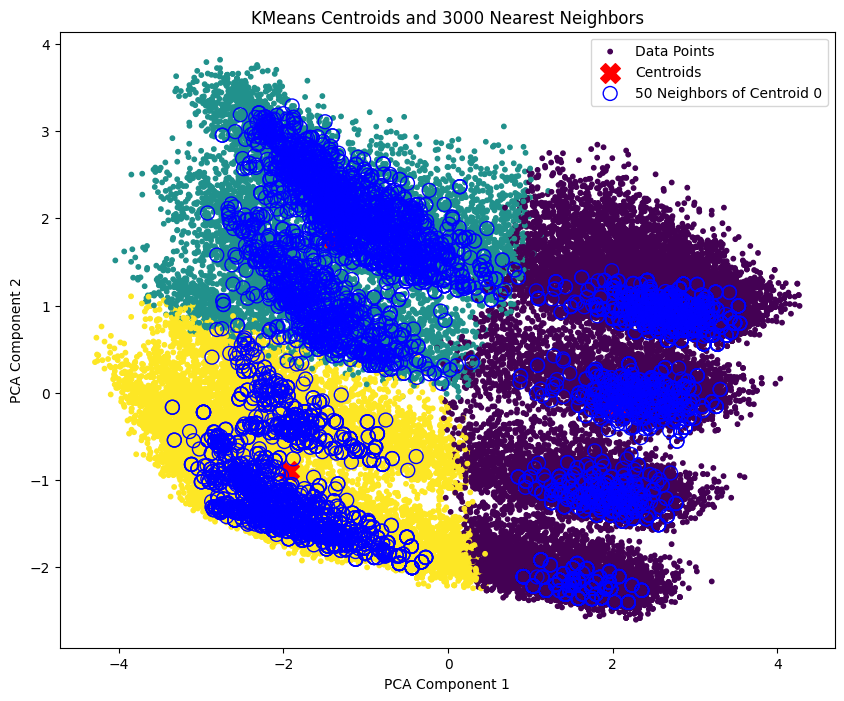

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

path = '/content/features.csv'
dataset = pd.read_csv(path).drop('image_id',axis = 1)

# fit K-means with 3 clusters on our dataset.
#The numbers of
kme = KMeans(n_clusters=3)
kme.fit(dataset)

# we should have 3 vectors for 3 centroids.
print(kme.cluster_centers_.shape) # (3, 10)

# initialize NearestNeighbor with 50 neighbors and fit our dataset.
knn = NearestNeighbors(n_neighbors=50, metric='cosine')
knn.fit(dataset)

# initialize NearestNeighbor with 3000 neighbors and fit our dataset.
knn1 = NearestNeighbors(n_neighbors=3000, metric='cosine')
knn1.fit(dataset)

# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
dataset_2d = pca.fit_transform(dataset)
centroids_2d = pca.transform(kme.cluster_centers_)

# Get the 50 nearest neighbors for each centroid
#nearest_neighbors_50 = knn.kneighbors(kme.cluster_centers_, return_distance=False)

# Get the 3000 nearest neighbors for each centroid
nearest_neighbors_3000 = knn1.kneighbors(kme.cluster_centers_, return_distance=False)

# Plot centroids and 50 nearest neighbors
plt.figure(figsize=(10, 8))

# Plot the dataset points
plt.scatter(dataset_2d[:, 0], dataset_2d[:, 1], c=kme.labels_, s=10, cmap='viridis', label='Data Points')

# Plot the centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='red', label='Centroids', marker='X')

# Highlight nearest neighbors (50 neighbors)
for i, neighbors in enumerate(nearest_neighbors_3000):
    plt.scatter(dataset_2d[neighbors, 0], dataset_2d[neighbors, 1], edgecolors='blue', facecolors='none', s=100, label=f'50 Neighbors of Centroid {i}' if i == 0 else "")

plt.title("KMeans Centroids and 3000 Nearest Neighbors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


# **Phase 6: Prediction**

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


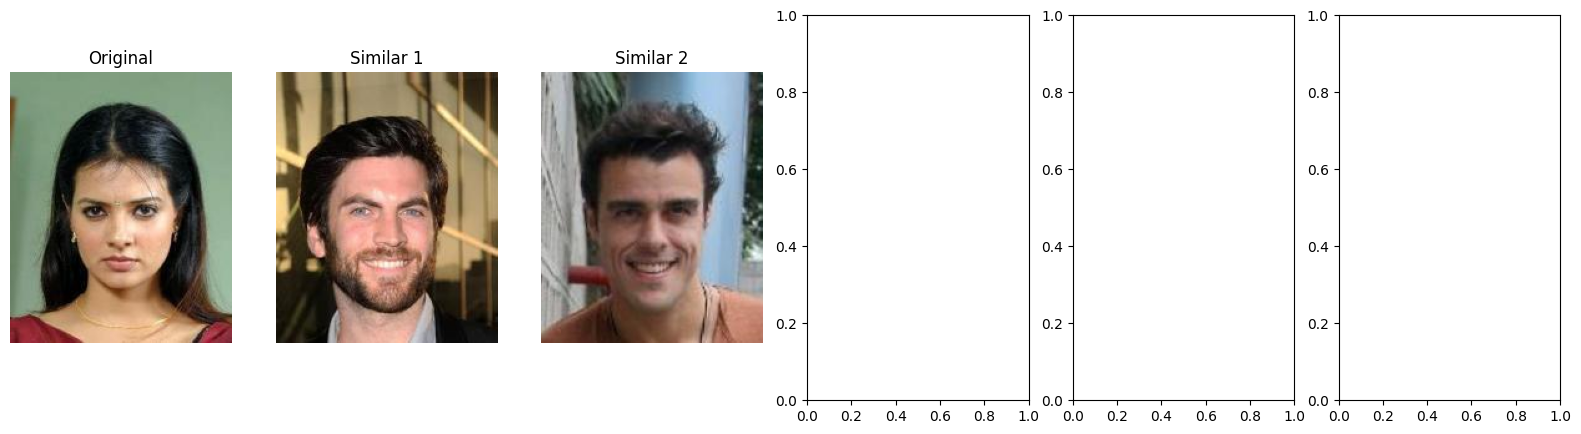

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


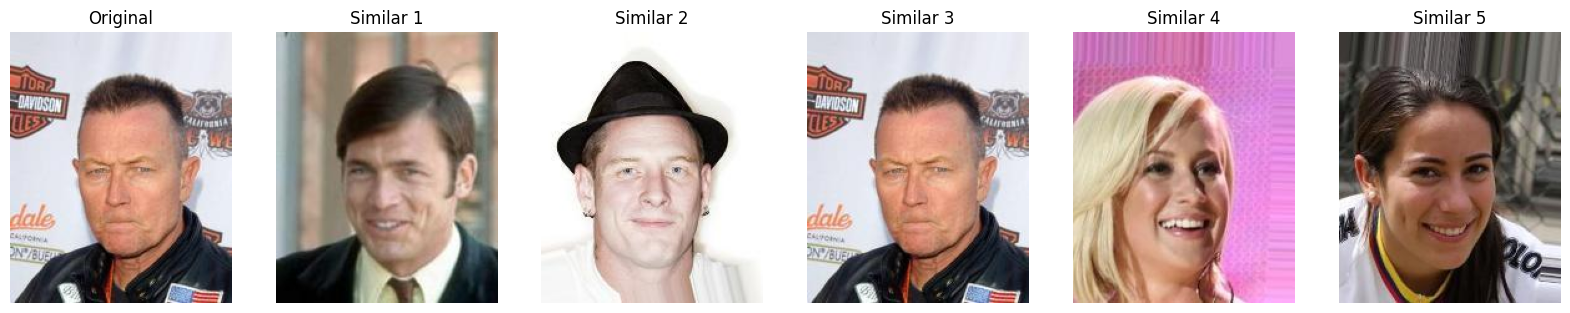

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


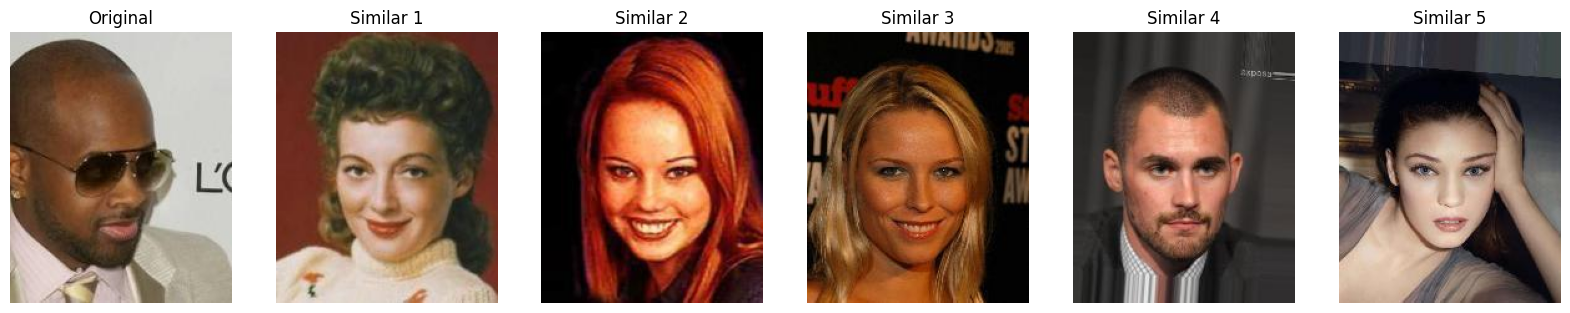

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


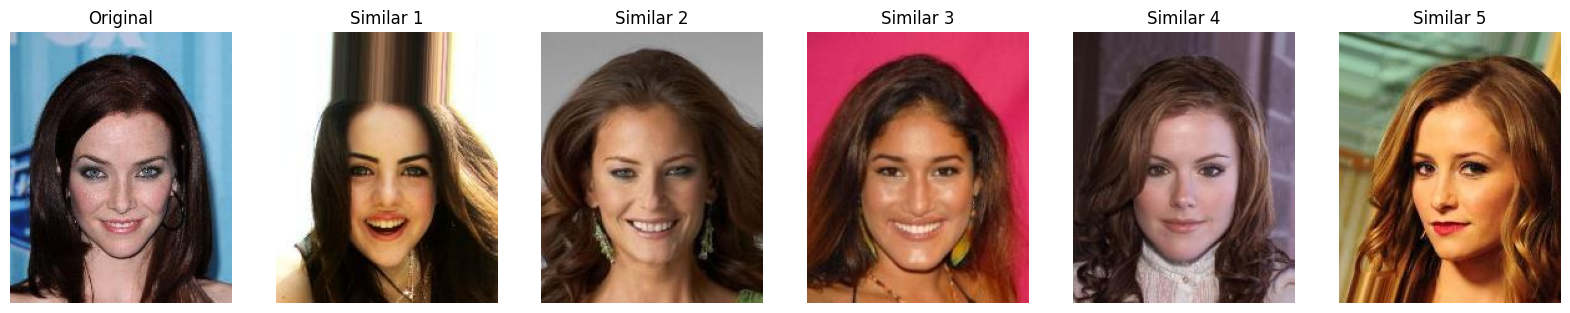

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


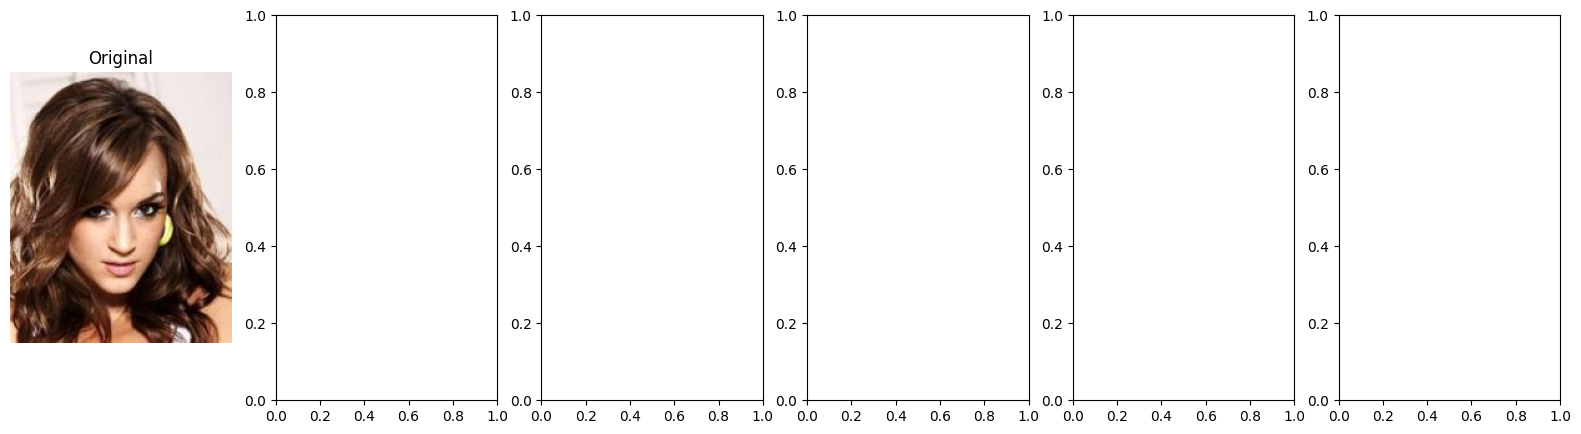

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


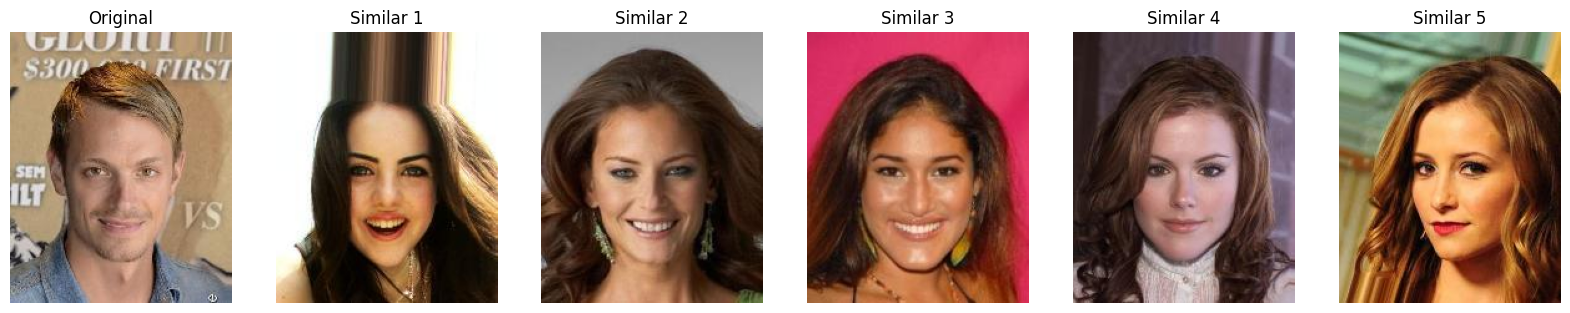

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


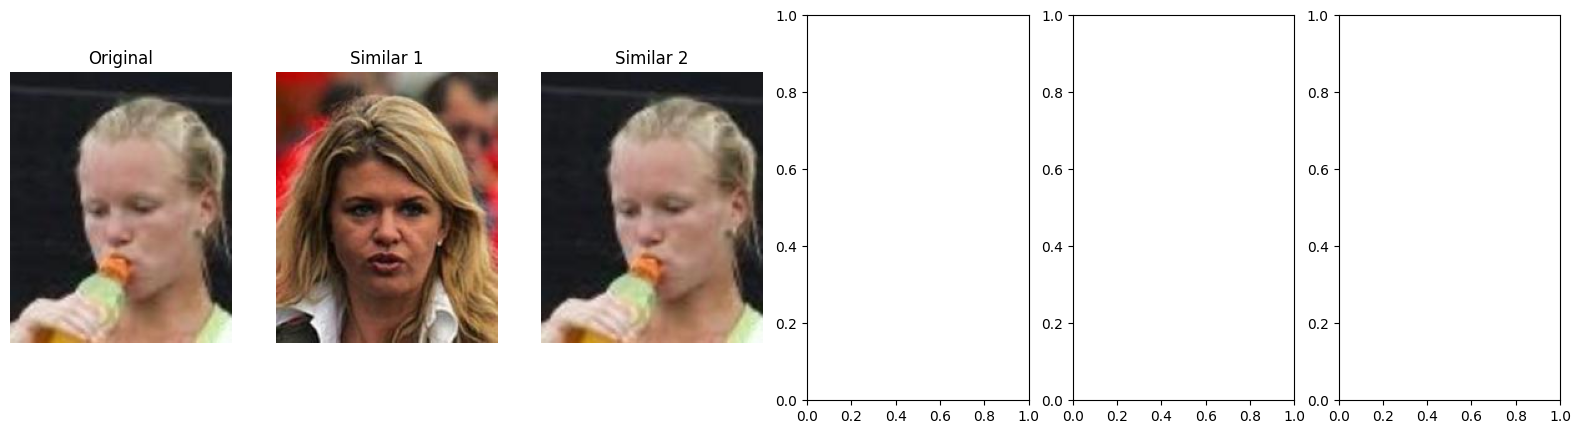

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


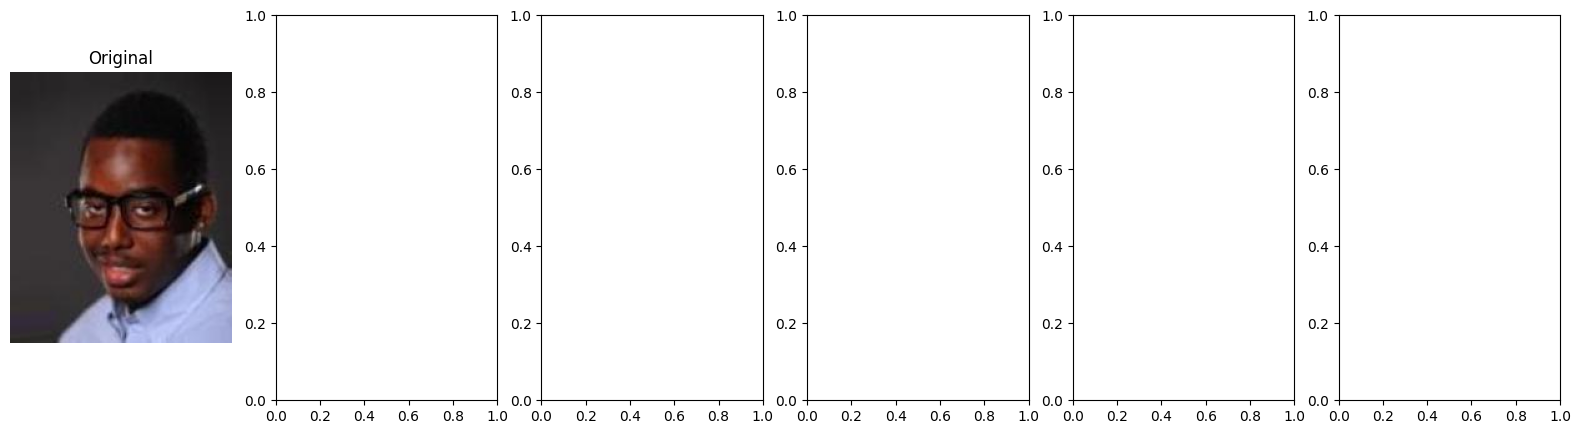

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


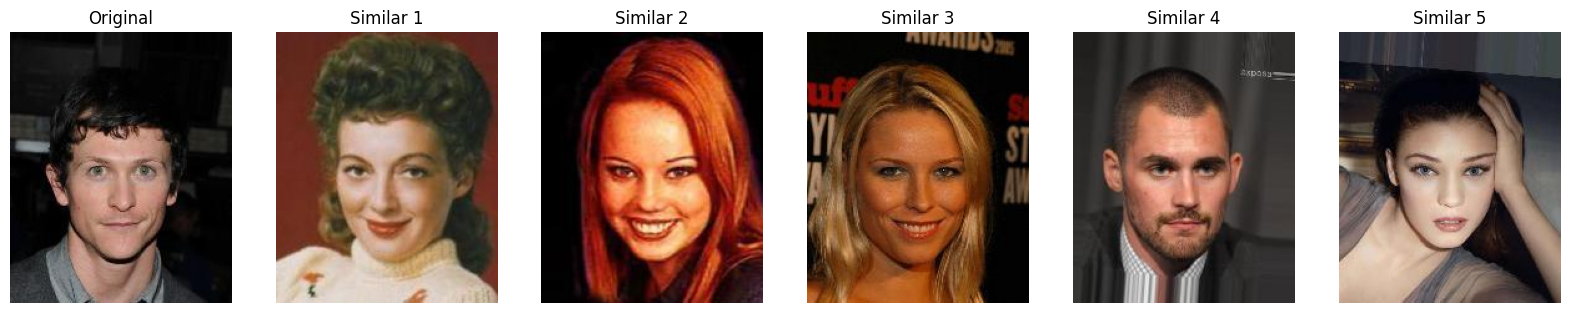

<ipython-input-41-ef25d364f9f0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)


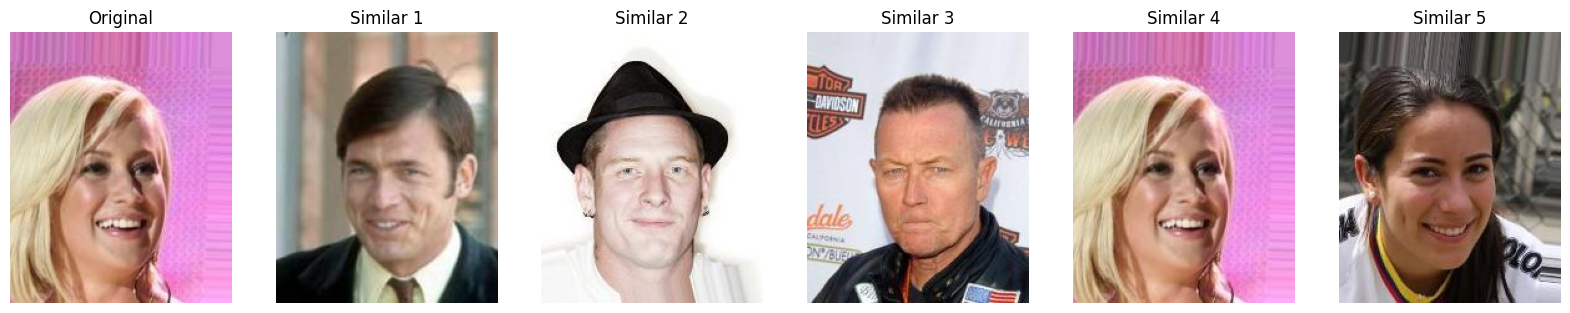

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Load the features data
test_features_path = 'test_features.csv'
test_features = pd.read_csv(test_features_path)

# Load the trained clustering model or define the same MeanShift clustering
# Assuming you already have the clusters centers or you can reinitialize MeanShift with saved parameters
mean_shift_model = MeanShift(bandwidth=1.5)  # Use the same bandwidth or parameters as trained previously
X = test_features[optimum_features].values  # Replace with actual feature names
mean_shift_model.fit(X)
cluster_centers = mean_shift_model.cluster_centers_
labels = mean_shift_model.labels_

# Assign each image to a cluster
test_folder_path = 'test'
image_files = [f for f in os.listdir(test_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Update test_features dataframe with assigned cluster labels
test_features['Cluster_Label'] = labels

# Save the new file with cluster labels
test_features.to_csv('test_features2.csv', index=False)

# Select 10 random images from test folder
random_images = random.sample(image_files, 10)

# Function to calculate similarity (Euclidean distance) between features
def calculate_similarity(feature_vector, other_features):
    return np.linalg.norm(other_features - feature_vector, axis=1)

# Step 2: Visualize each random image with 5 similar images from its cluster
for image_file in random_images:
    image_path = os.path.join(test_folder_path, image_file)
    img = cv2.imread(image_path)
    cluster_label = test_features.loc[test_features['image_id'] == image_file, 'Cluster_Label'].values[0]

    # Get all images in the same cluster
    cluster_images = test_features[test_features['Cluster_Label'] == cluster_label]

    # Get feature vector of the selected image
    image_features = test_features.loc[test_features['image_id'] == image_file, optimum_features].values[0]

    # Calculate similarity and sort images in the same cluster by similarity
    cluster_images['similarity'] = calculate_similarity(image_features, cluster_images[optimum_features].values)
    similar_images = cluster_images.sort_values('similarity').head(6)  # 5 closest images + original image

    # Display the images
    fig, axs = plt.subplots(1, 6, figsize=(20, 5))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[0].axis('off')

    for i, similar_image in enumerate(similar_images[1:].itertuples(), start=1):
        similar_image_path = os.path.join(test_folder_path, similar_image.image_id)
        similar_img = cv2.imread(similar_image_path)
        axs[i].imshow(cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f'Similar {i}')
        axs[i].axis('off')

    plt.show()
